In [ ]:
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
listings = pd.read_csv('/content/drive/MyDrive/RegressionProject/listings_final_dataset.csv')

In [ ]:
listings.shape

(189210, 136)

In [ ]:
listings = listings.sample(frac=0.6)

In [ ]:
#listings.to_csv('/content/drive/MyDrive/RegressionProject/listings_final_dataset_sample.csv')

In [ ]:
#listings = pd.read_csv('/content/drive/MyDrive/RegressionProject/listings_final_dataset_sample.csv')

In [ ]:
columns_to_drop = [
    'bathrooms', 'source_city_scrape',
    'source_previous_scrape', 'bathrooms_text_0_baths', 'bathrooms_text_0_shared_baths',
    'bathrooms_text_1_bath', 'bathrooms_text_1_private_bath', 'bathrooms_text_1_shared_bath',
    'bathrooms_text_1.5_baths', 'bathrooms_text_1.5_shared_baths', 'bathrooms_text_2_baths',
    'bathrooms_text_2_shared_baths', 'bathrooms_text_2.5_baths', 'bathrooms_text_2.5_shared_baths',
    'bathrooms_text_3_baths', 'bathrooms_text_3_shared_baths', 'bathrooms_text_3.5_baths',
    'bathrooms_text_3.5_shared_baths', 'bathrooms_text_4_baths', 'bathrooms_text_4_shared_baths',
    'bathrooms_text_4.5_baths', 'bathrooms_text_4.5_shared_baths', 'bathrooms_text_5_baths',
    'bathrooms_text_5.5_baths', 'bathrooms_text_6_shared_baths', 'bathrooms_text_7.5_baths',
    'bathrooms_text_half-bath', 'bathrooms_text_private_half-bath', 'bathrooms_text_shared_half-bath'
]

# Dropping the columns
listings = listings.drop(columns=columns_to_drop)

In [ ]:
numerical_columns = ['accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
                     'availability_30', 'number_of_reviews','calculated_host_listings_count', 'host_days_active',
                     'description_text_length',
                     'distance_to_nyc']

In [ ]:
listings.shape

(113526, 107)

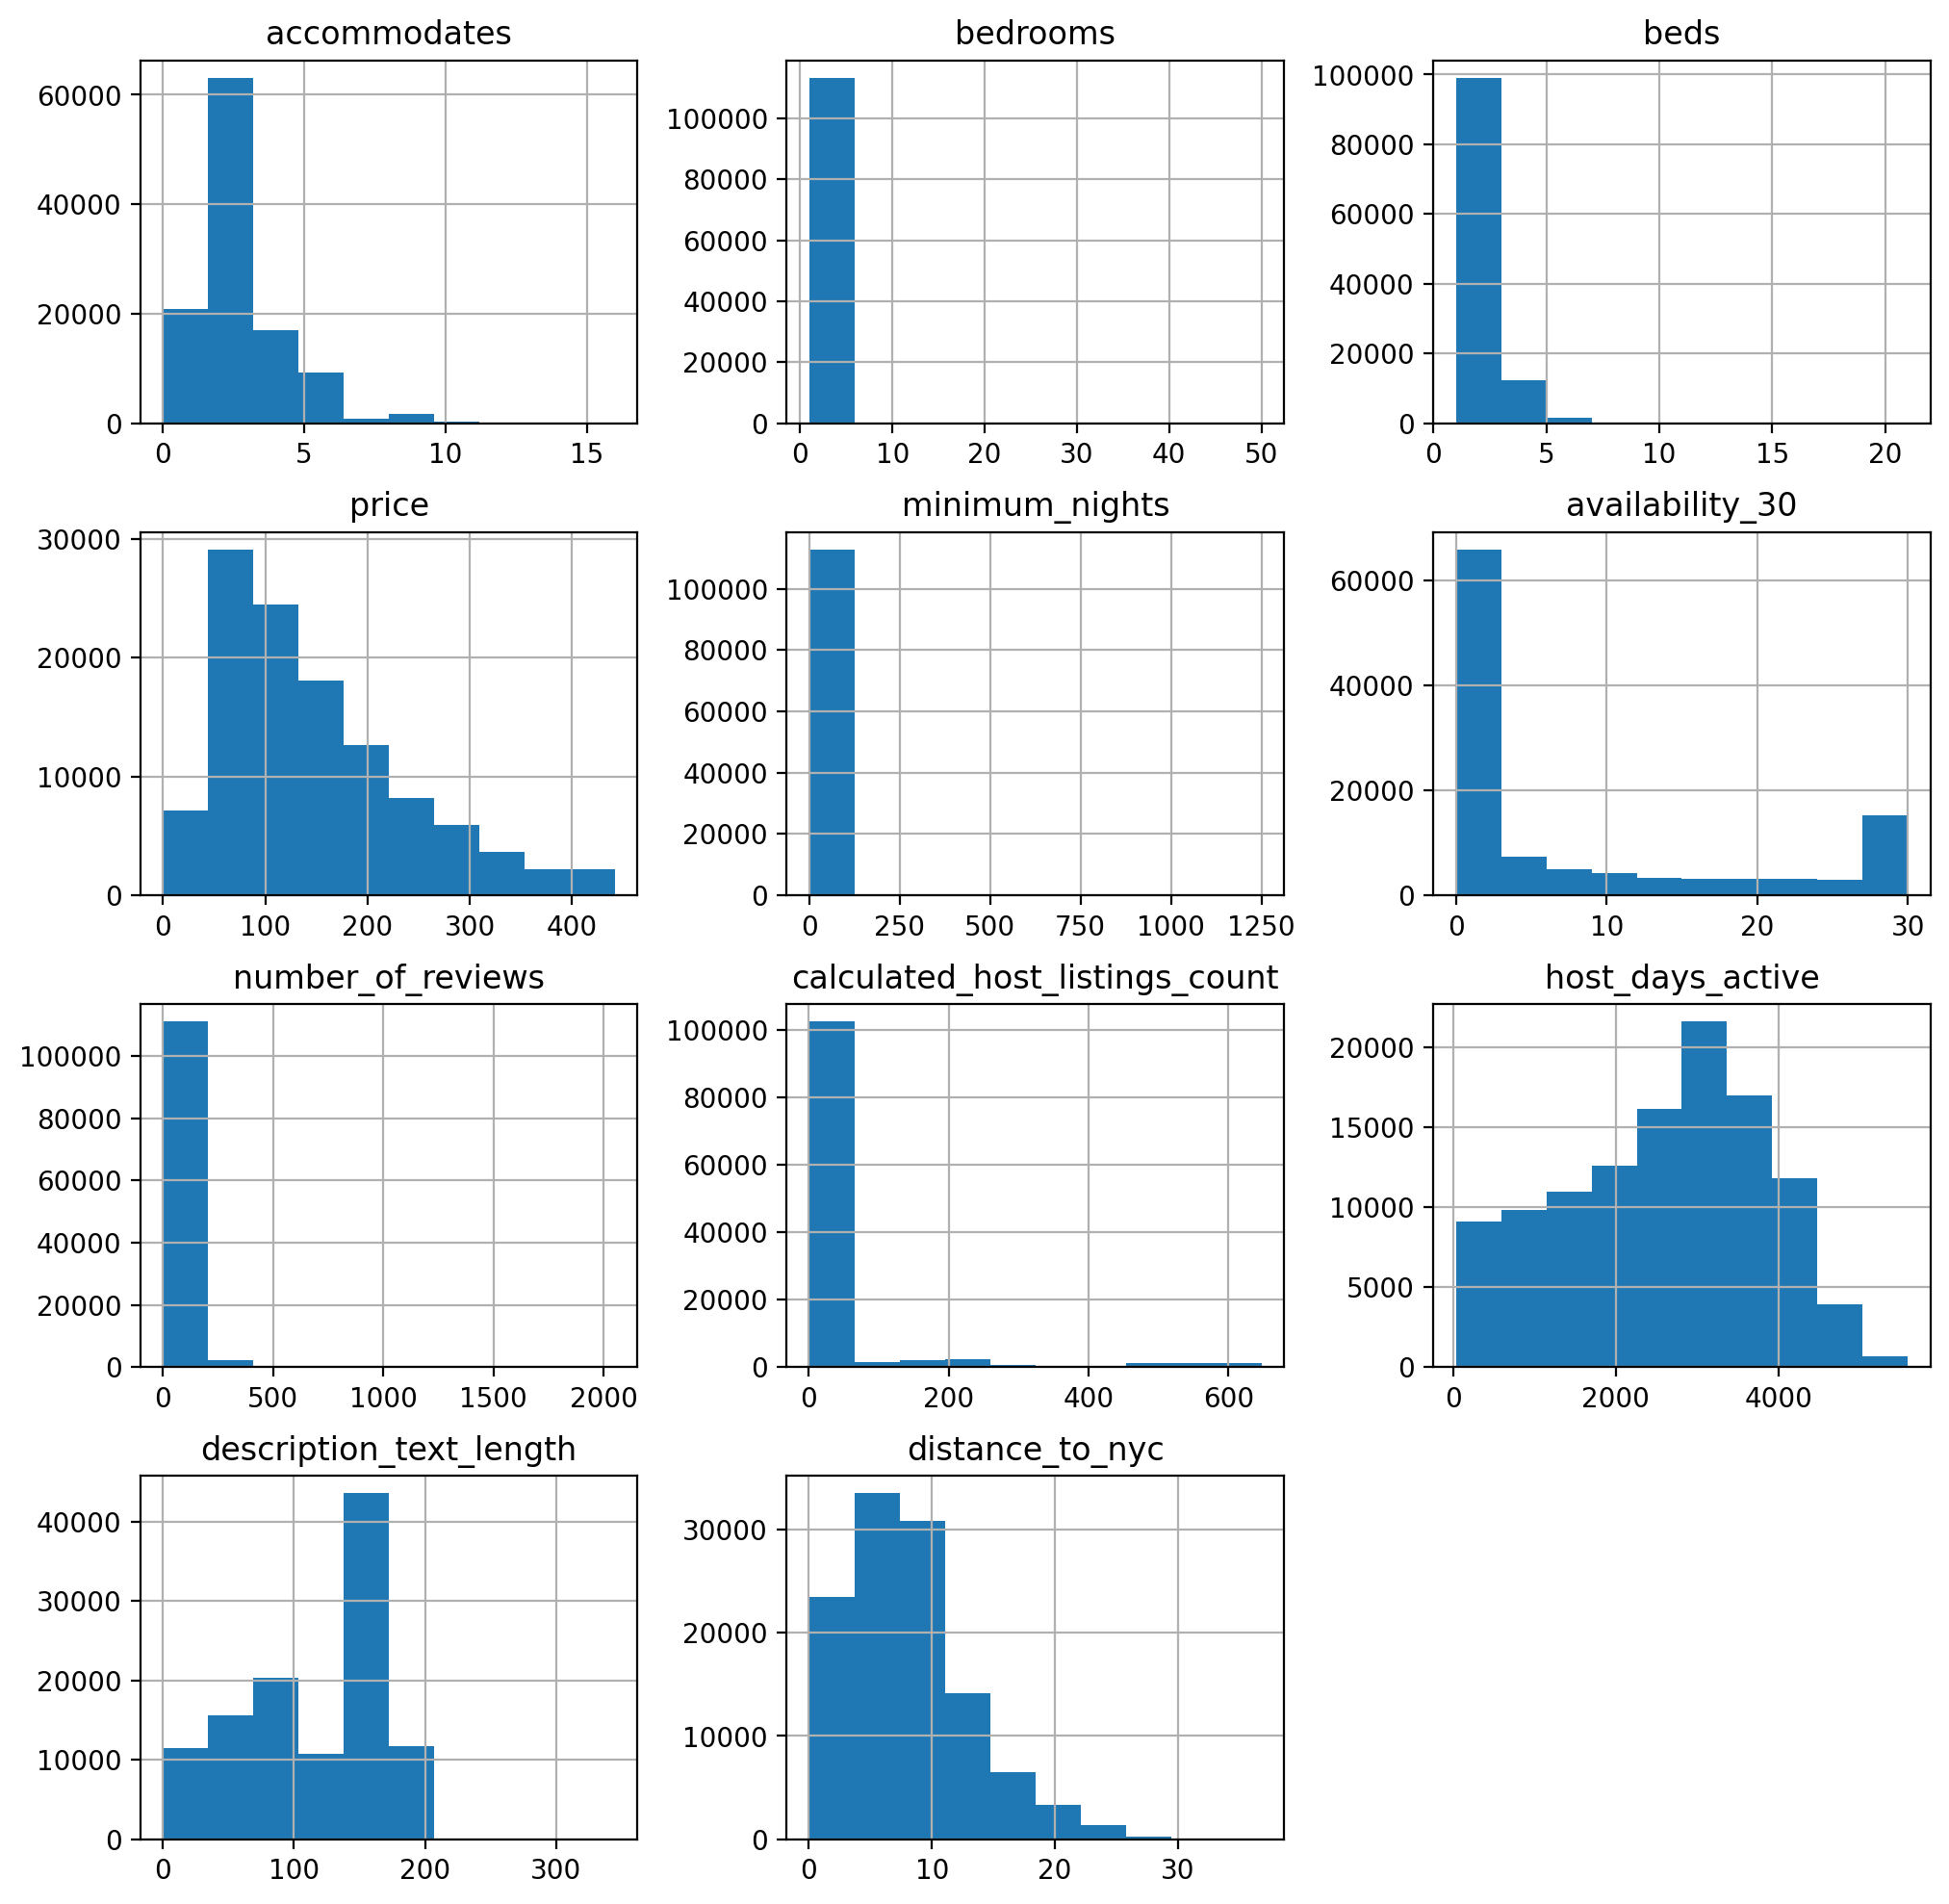

In [ ]:
listings[numerical_columns].hist(figsize=(12,12));

In [ ]:
listings_copy = listings.copy()

# Log transforming right-skewed columns. Remove items not to be transformed
log_columns = [i for i in numerical_columns if i not in ['availability_30', 'host_days_active',
                                                               'description_text_length']]

for col in log_columns:
    listings_copy[col] = listings_copy[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01 as log(0) is undefined
    listings_copy[col] = np.log(listings_copy[col])

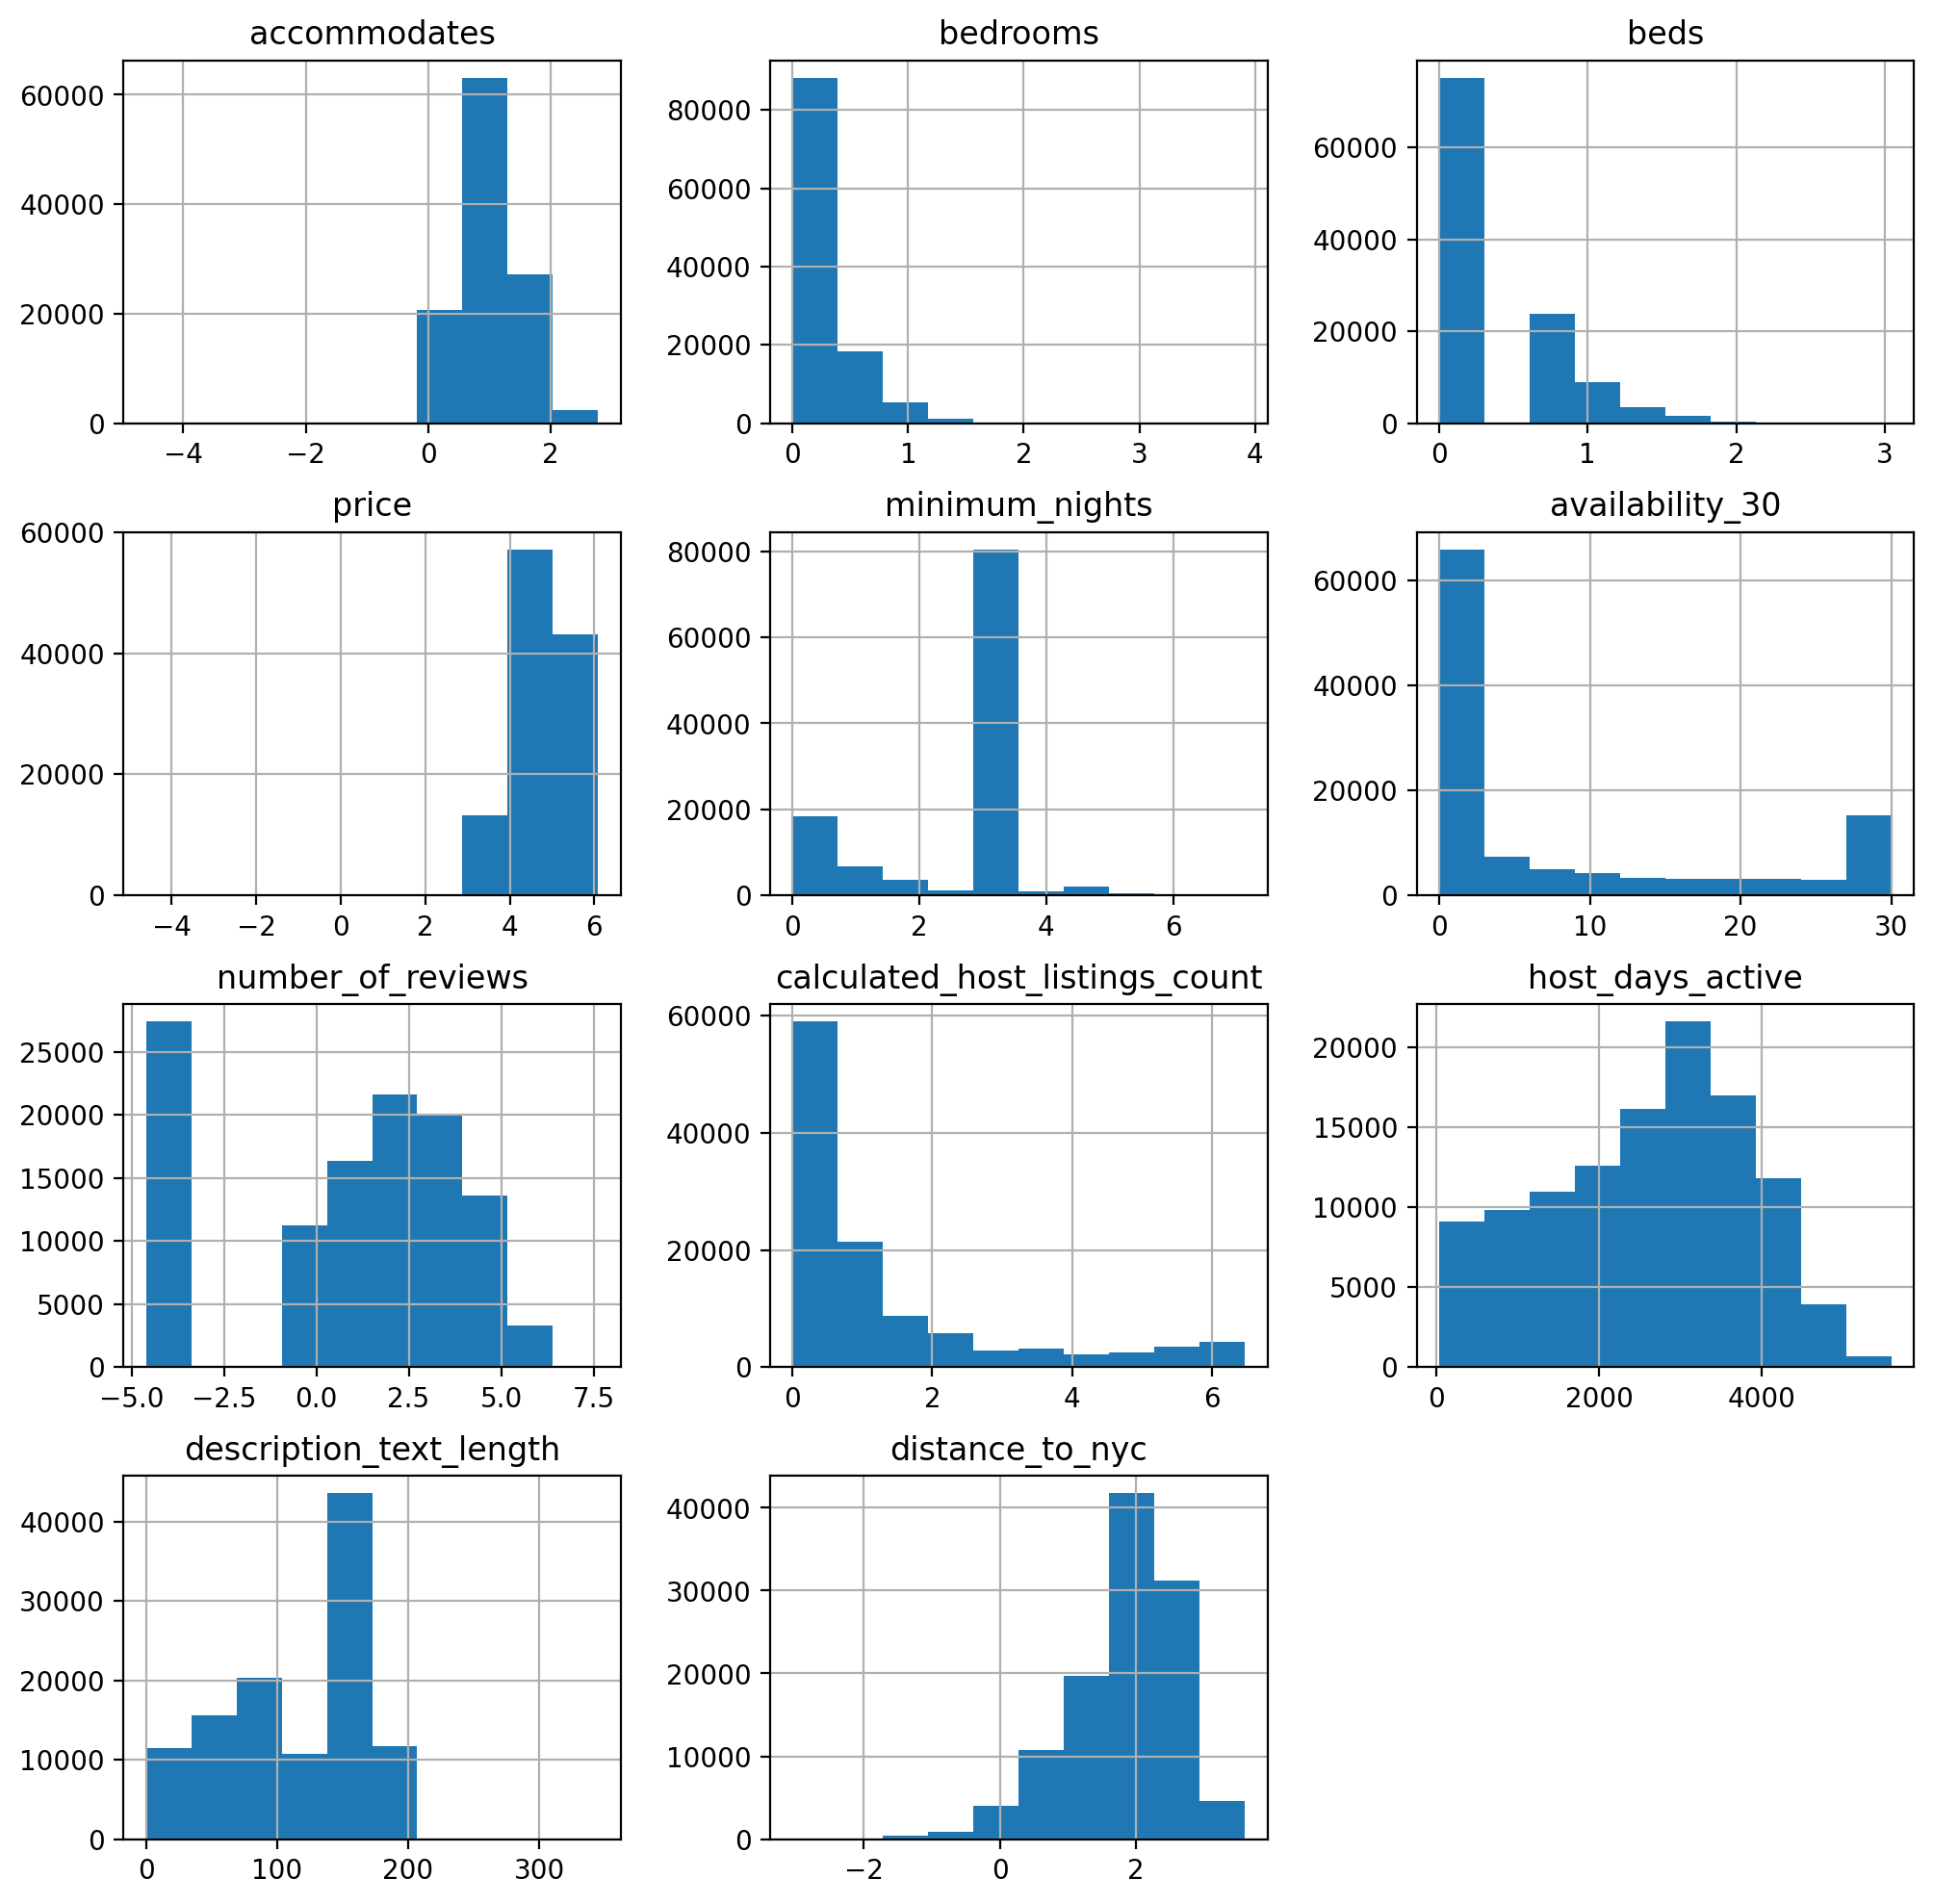

In [ ]:
listings_copy[numerical_columns].hist(figsize=(12,12));

In [ ]:
features = [x for x in listings_copy.columns if x not in ['price', 'id']]

X = listings_copy[features]
y = listings_copy.price

In [ ]:
y.head(20)

147135    3.912023
54425     4.219508
175796    4.248495
41026     5.351858
59122     4.553877
78078     4.007333
6226      4.700480
46524     5.521461
138444    5.963579
14875     5.318120
47560     3.737670
70976     5.669881
19276     4.779123
88381     5.459586
13707     4.488636
148216    5.416100
185155    4.382027
116747    5.988961
128449    5.379897
344       5.010635
Name: price, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numerical_columns = ['accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
                     'availability_30', 'number_of_reviews','calculated_host_listings_count', 'host_days_active',
                     'description_text_length',
                     'distance_to_nyc']

In [ ]:
# copy of cross_validation datasets
X_train_ss = X_train.copy()
X_test_ss = X_test.copy()

# To standardise all continuous numerical features
numerical_columns.remove('price')

# Apply standardization
for i in numerical_columns:

    # Instantiate StandardScalar
    ss = StandardScaler()

    # Fit and transform the training data
    X_train_ss[i] = ss.fit_transform(X_train_ss[[i]])

    # Transform the testing data
    X_test_ss[i] = ss.transform(X_test_ss[[i]])

In [ ]:
# Instantiate model
lr = LinearRegression()

# Cross validation
lr_scores = cross_val_score(lr, X_train_ss, y_train, cv=5)

print('Results from: Linear Regression')
print(f'-----------------------------------')
print(f"Mean CV score: {lr_scores.mean()}")
print(f"CV score std: {lr_scores.std()}")

# Fit lr model
lr.fit(X_train_ss,y_train)

# Score lr model on training and test data
lr_score_train = lr.score(X_train_ss, y_train)
lr_score_test = lr.score(X_test_ss, y_test)
print(f'\nTraining R2: {lr_score_train}')
print(f'Testing R2: {lr_score_test}')

# Predict
lr_pred_train = lr.predict(X_train_ss)
lr_pred_test = lr.predict(X_test_ss)

print(f'\nTraining RMSE: {sqrt(mean_squared_error(np.exp(y_train), np.exp(lr_pred_train)))}')
print(f'Testing RMSE: {sqrt(mean_squared_error(np.exp(y_test), np.exp(lr_pred_test)))}')

# Print out coefficients.
lr_coef = pd.Series(lr.coef_, index=X_train_ss.columns).sort_values(ascending=False)
print("\nCoefficient:\n",lr_coef.head())

Results from: Linear Regression
-----------------------------------
Mean CV score: 0.6168750054618666
CV score std: 0.023875675278038144

Training R2: 0.6320418119851718
Testing R2: 0.6343076200512623

Training RMSE: 62.82057565102432
Testing RMSE: 63.080178483725135

Coefficient:
 property_category_svc_apt_hotel           0.272378
neighbourhood_group_cleansed_manhattan    0.162898
gym                                       0.140817
review_scores_location_no_reviews         0.127958
review_scores_rating_no_reviews           0.126856
dtype: float64


{'colsample_bytree': 0.9926800709845967,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 7.0,
 'min_child_weight': 57.46343599170297,
 'n_estimators': 260.1460798164766,
 'reg_alpha': 3.3385654735480403,
 'reg_lambda': 1.7250351575283862,
 'subsample': 0.893761632703847}

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install xgboost

In [ ]:
!pip install bayesian-optimization

In [ ]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the XGBoost objective
def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
    params = {
        # Parameters are rounded as required by XGBoost
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'random_state': 42
    }
    xgb_model = xgb.XGBRegressor(**params)
    cv_score = np.mean(cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2'))
    return cv_score

# Define the parameter bounds
param_bounds = {
    'max_depth': (3, 7),  # Range from 3 to 7
    'learning_rate': (0.01, 0.3),  # Range from 0.01 to 0.3
    'n_estimators': (100, 1000),  # Range from 100 to 1000
    'gamma': (0, 1),  # Range from 0 to 1
    'min_child_weight': (1, 200),  # Range from 1 to 200
    'subsample': (0.5, 1.0),  # Range from 0.5 to 1.0
    'colsample_bytree': (0.5, 1.0),  # Range from 0.5 to 1.0
    'reg_alpha': (0, 10),  # Range from 0 to 10
    'reg_lambda': (0, 10),  # Range from 0 to 10
}

# Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=25)

# Best parameters
best_params = optimizer.max['params']


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7252    | 0.6873    | 0.9507    | 0.2223    | 5.395     | 32.05     | 240.4     | 0.5808    | 8.662     | 0.8006    |
| 2         | 0.7837    | 0.854     | 0.02058   | 0.2913    | 6.33      | 43.26     | 263.6     | 1.834     | 3.042     | 0.7624    |
| 3         | 0.7206    | 0.716     | 0.2912    | 0.1874    | 3.558     | 59.14     | 429.7     | 4.561     | 7.852     | 0.5998    |
| 4         | 0.6724    | 0.7571    | 0.5924    | 0.02347   | 5.43      | 34.93     | 158.5     | 9.489     | 9.656     | 0.9042    |
| 5         | 0.7587    | 0.6523    | 0.09767   | 0.2084    | 4.761     | 25.29     | 545.7     | 0.3439    | 9.093     | 0.6294    |
| 6         | 0.7307    | 0.8313    | 0.3117    | 0.1608    | 

In [ ]:
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

In [ ]:
best_params

{'colsample_bytree': 1.0,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 61.23507152084262,
 'n_estimators': 265,
 'reg_alpha': 1.5752099351911442,
 'reg_lambda': 0.0,
 'subsample': 0.9363526970420512}

In [ ]:
# Train model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Predictions and Evaluations
train_preds = best_xgb_model.predict(X_train)
test_preds = best_xgb_model.predict(X_test)

# R2 Scores
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

# Print scores
print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Train R2 Score: 0.875517543804254
Test R2 Score: 0.816000235914587
Training RMSE: 0.2284511030087224
Testing RMSE: 0.2762834664664392


In [ ]:
test_preds_df = pd.DataFrame(test_preds, index=X_test.index, columns=['predictions'])
train_preds_df = pd.DataFrame(train_preds, index=X_train.index, columns=['predictions'])

In [ ]:
original_test_data = X_test.copy()
original_test_data['price'] = y_test
original_test_data = pd.merge(original_test_data, test_preds_df, left_index=True, right_index=True)

In [ ]:
y_test

80770     5.736572
233       4.094345
41719     4.174387
138798    5.616771
176050    4.248495
54121     4.605170
121245    5.521461
47459     4.290459
159918    4.553877
84839     5.241747
147918    5.010635
178339    4.762174
40455     4.510860
71105     3.988984
119577    3.332205
168827    4.317488
71116     4.043051
47729     4.867534
25630     5.686975
3918      3.688879
83452     5.361292
161774    4.189655
16976     4.219508
54188     4.812184
81735     5.105945
154667    5.298317
105359    4.919981
49146     4.442651
88098     5.225747
160039    5.780744
168104    5.703782
103861    4.700480
118977    4.867534
90259     5.468060
97592     4.615121
97806     5.117994
118979    4.867534
184135    4.564348
97611     3.555348
98137     5.703782
109627    4.317488
87666     5.533389
19660     5.105945
120771    4.553877
147304    5.010635
39659     5.416100
185140    3.610918
68224     5.105945
173602    5.337538
61763     5.010635
152806    3.555348
19647     6.049733
163151    5.

In [ ]:
original_test_data.head(10)

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,reviews_per_month,host_days_active,check_in_24h,air_conditioning,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,washer,elevator,gym,child_friendly,parking,garden,host_greeting,hot_tub,pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,wheelchair_access,event_suitable,building_staff,wifi,description_text_length,distance_to_nyc,sentiment_compound,host_response_time_a_few_days_or_more,host_response_time_unknown,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,host_response_rate_0-49%,host_response_rate_50-79%,host_response_rate_80-94%,host_response_rate_95-100%,host_response_rate_unknown,host_acceptance_rate_0-49%,host_acceptance_rate_50-69%,host_acceptance_rate_70-89%,host_acceptance_rate_90-100%,host_acceptance_rate_unknown,neighbourhood_group_cleansed_bronx,neighbourhood_group_cleansed_brooklyn,neighbourhood_group_cleansed_manhattan,neighbourhood_group_cleansed_queens,neighbourhood_group_cleansed_staten_island,room_type_entire_home/apt,room_type_hotel_room,room_type_private_room,room_type_shared_room,review_scores_rating_0-79/100,review_scores_rating_no_reviews,review_scores_accuracy_0-8/10,review_scores_accuracy_no_reviews,review_scores_cleanliness_0-8/10,review_scores_cleanliness_no_reviews,review_scores_checkin_0-8/10,review_scores_checkin_no_reviews,review_scores_communication_0-8/10,review_scores_communication_no_reviews,review_scores_location_0-8/10,review_scores_location_no_reviews,review_scores_value_0-8/10,review_scores_value_no_reviews,days_since_first_review_0-6_months,days_since_first_review_1-2_years,days_since_first_review_2-3_years,days_since_first_review_6-12_months,days_since_first_review_>4_years,days_since_first_review_no_reviews,days_since_last_review_0-3_months,days_since_last_review_0.5-1_year,days_since_last_review_1-2_years,days_since_last_review_3-6_months,days_since_last_review_>2_years,days_since_last_review_no_reviews,property_category_apartment,property_category_condo,property_category_hostel,property_category_svc_apt_hotel,price,test_predictions
80770,0,1,0.693147,0.000000,0.000000,3.401197,1125,30,60,90,365,-4.605170,0,0,0,1.098612,0.00,3263.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0.889568,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,5.736572,5.801979
233,0,1,0.000000,0.000000,0.000000,3.401197,120,27,57,87,87,4.499810,1,0,0,0.000000,0.65,4500.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,183,2.507385,0.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,4.094345,4.158946
41719,1,0,0.000000,0.000000,0.000000,3.401197,80,0,0,0,243,1.609438,2,0,1,0.693147,0.29,1230.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,76,2.648526,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4.174387,3.896964
138798,0,1,1.386294,0.693147,0.693147,1.945910,12,0,0,0,0,1.609438,0,0,0,0.000000,0.07,4259.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,166,1.630258,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,5.616771,5.551856
176050,0,1,0.693147,0.000000,0.000000,0.000000,365,30,60,90,364,2.564949,13,0,0,1.791759,1.21,658.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
original_train_data = X_train.copy()
original_train_data['price'] = y_train
original_train_data = pd.merge(original_train_data, train_preds_df, left_index=True, right_index=True)

In [ ]:
combined_data = pd.concat([original_train_data, original_test_data])

In [ ]:
combined_data.shape

(113526, 107)

In [ ]:
combined_data_2 = combined_data[['predictions']]

In [ ]:
combined_data_2.head(10)

,predictions
177042,4.391365
145085,4.857604
108317,3.744263
37012,4.422512
189166,3.926604
70010,3.832036
5683,4.216989
72719,3.806339
132510,5.617229
161296,3.864763


In [ ]:
listings_copy.head(10)

,property_category_svc_apt_hotel,property_category_hostel,bedrooms,accommodates,host_response_time_within_an_hour,gym,garden,pool,beds,property_category_apartment,cooking_basics,minimum_nights,washer,distance_to_nyc,price,id
147135,0,1,0.000000,0.693147,0,0.0,0.0,0.0,0.000000,0,1.0,3.401197,1.0,2.891643,3.912023,33394700
54425,0,1,0.000000,0.000000,1,0.0,0.0,0.0,0.000000,0,0.0,3.401197,0.0,2.165539,4.219508,842293165106816729
175796,0,1,0.000000,0.693147,1,0.0,1.0,0.0,0.000000,0,1.0,3.401197,1.0,2.428243,4.248495,550135601428139032
41026,1,0,0.693147,1.386294,1,0.0,0.0,0.0,0.693147,0,1.0,3.401197,0.0,1.897161,5.351858,594397894022042503
59122,0,1,0.000000,0.693147,0,0.0,0.0,0.0,0.000000,0,1.0,3.401197,1.0,2.258131,4.553877,552836837466430326
78078,0,1,0.000000,0.693147,1,0.0,1.0,0.0,0.693147,0,0.0,0.000000,0.0,3.030856,4.007333,659318499793428434
6226,0,1,0.000000,0.000000,1,0.0,0.0,0.0,0.000000,0,1.0,3.401197,0.0,1.767101,4.700480,11903201
46524,1,0,0.000000,1.386294,1,0.0,0.0,0.0,0.000000,0,1.0,3.401197,0.0,0.860975,5.521461,842228816148192703
138444,1,0,1.098612,1.791759,0,0.0,0.0,0.0,1.098612,0,0.0,3.401197,0.0,1.612431,5.963579,37776968
14875,0,1,0.000000,0.000000,0,0.0,0.0,1.0,0.000000,0,1.0,3.401197,1.0,2.401082,5.318120,36085870


In [ ]:
listings_copy = listings_copy[['property_category_svc_apt_hotel', 'property_category_hostel', 'bedrooms',
    'accommodates', 'host_response_time_within_an_hour', 'gym', 'garden',
    'pool', 'beds', 'property_category_apartment', 'cooking_basics',
    'minimum_nights', 'washer', 'distance_to_nyc', 'id']]

In [ ]:
original_data = pd.merge(listings_copy, combined_data_2, left_index=True, right_index=True)

In [ ]:
original_data.to_csv('/content/drive/MyDrive/RegressionProject/predictions_df.csv')

In [ ]:
listings_copy.shape

(113526, 107)

In [ ]:
listings_copy.columns

Index(['id', 'host_is_superhost', 'host_identity_verified', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'availability_30',
       ...
       'days_since_last_review_0-3_months',
       'days_since_last_review_0.5-1_year', 'days_since_last_review_1-2_years',
       'days_since_last_review_3-6_months', 'days_since_last_review_>2_years',
       'days_since_last_review_no_reviews', 'property_category_apartment',
       'property_category_condo', 'property_category_hostel',
       'property_category_svc_apt_hotel'],
      dtype='object', length=107)

In [ ]:
test_preds_df.head(5)

,test_predictions
80770,5.801979
233,4.158946
41719,3.896964
138798,5.551856
176050,4.372437


In [ ]:
y_test.head(5)


80770     5.736572
233       4.094345
41719     4.174387
138798    5.616771
176050    4.248495
Name: price, dtype: float64

In [ ]:
!pip install joblib


In [ ]:
import joblib

# Save the model to a file
joblib.dump(best_xgb_model, '/content/drive/MyDrive/RegressionProject/xgb_model.joblib')

# Load the model from the file
model = joblib.load('/content/drive/MyDrive/RegressionProject/xgb_model.joblib')

In [ ]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9926800709845967, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=57.46343599170297, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=260,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

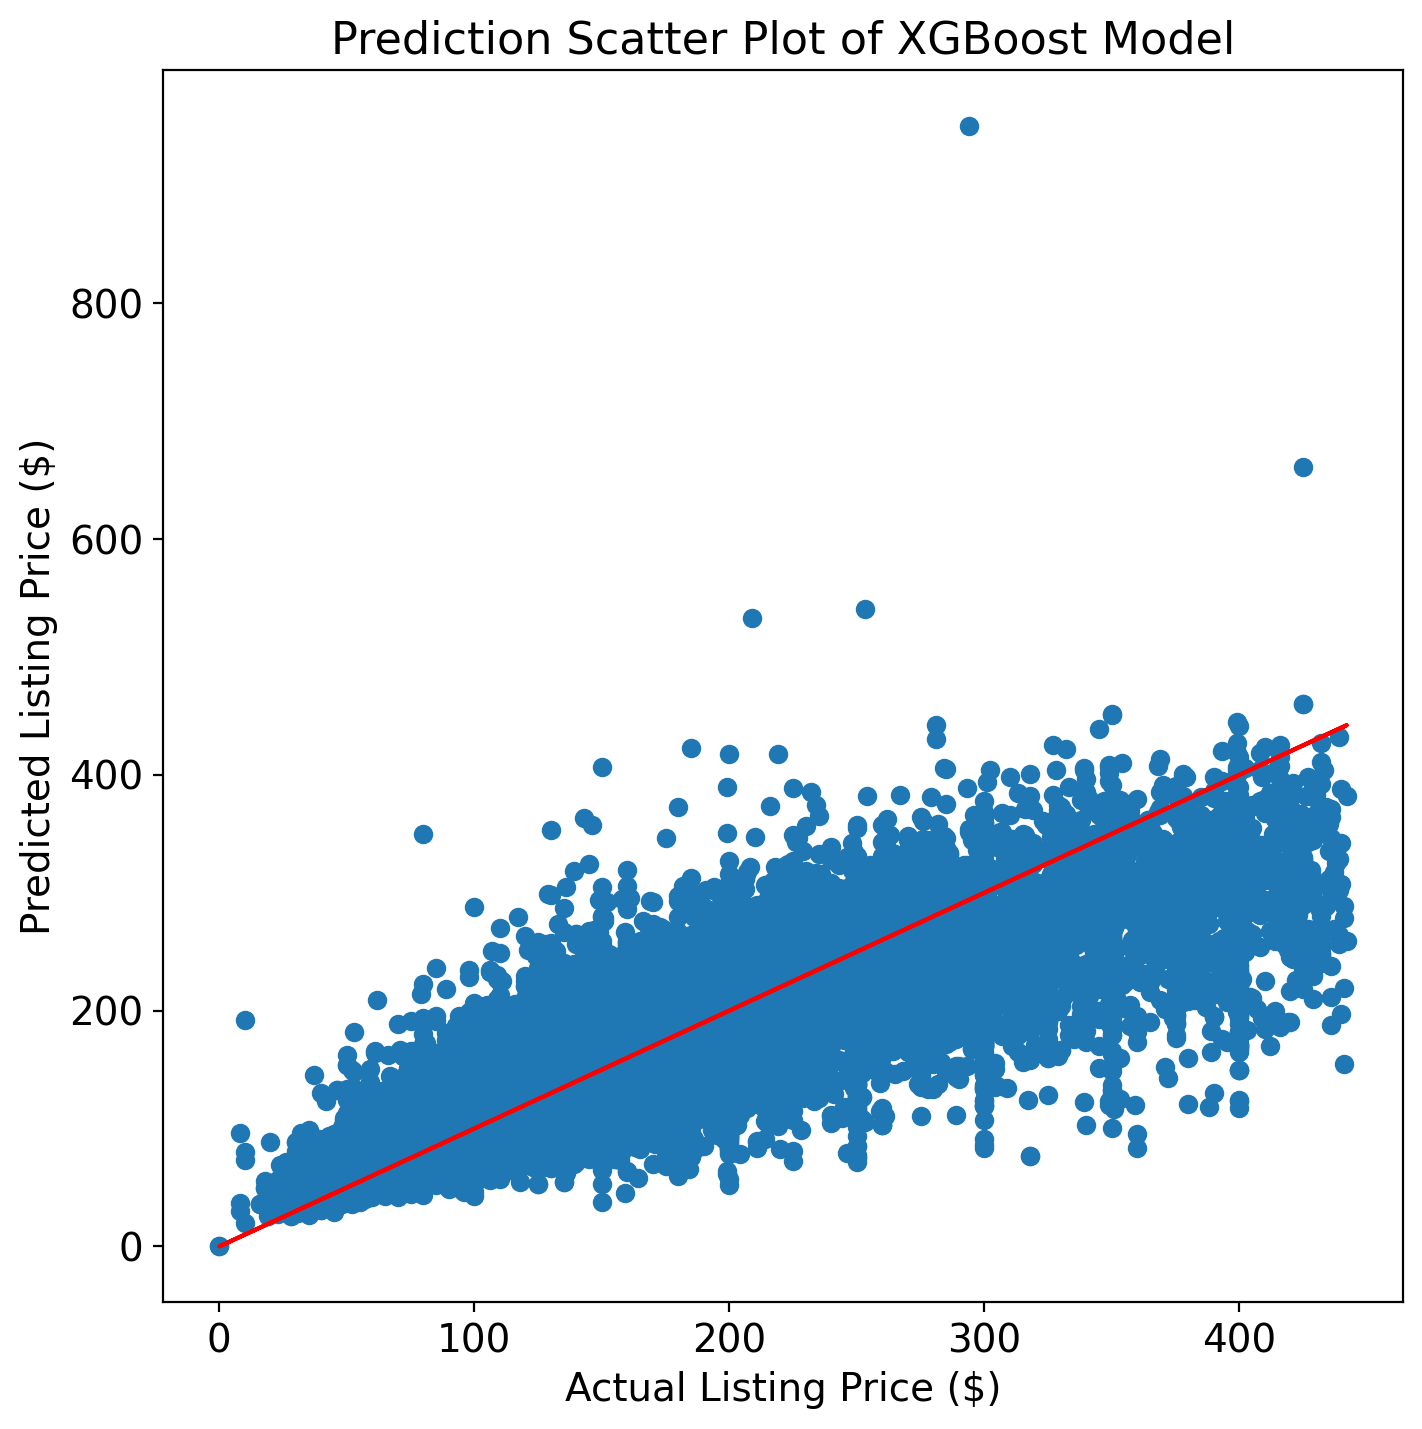

In [ ]:
plt.figure(figsize=(8,8))

plt.scatter(x = np.exp(y_test), y = np.exp(test_preds));
plt.plot(np.exp(y_test), np.exp(y_test), color = 'r');

plt.xlabel('Actual Listing Price ($)', size =14)
plt.ylabel("Predicted Listing Price ($)", size = 14)
plt.title('Prediction Scatter Plot of XGBoost Model',fontsize=16)

plt.xticks(size=14)
plt.yticks(size=14);

In [ ]:
pred_df = pd.DataFrame({'actual_price': np.exp(y_test),
                        'pred_price':np.exp(test_preds)})
pred_df['error'] =  abs(pred_df['actual_price'] - pred_df['pred_price'])
pred_df['percent_error'] = (abs(pred_df['actual_price'] - pred_df['pred_price'])/pred_df['actual_price'])*100
pred_df.sort_values('error',ascending=False).head(10)

,actual_price,pred_price,error,percent_error
129314,294.0,949.802002,655.802002,223.061905
164412,209.0,532.665161,323.665161,154.863713
146254,253.0,540.200134,287.200134,113.517840
107425,441.0,154.353973,286.646027,64.999099
21088,400.0,117.511497,282.488503,70.622126
124786,400.0,123.234657,276.765343,69.191336
6275,360.0,83.774582,276.225418,76.729283
145484,400.0,124.593864,275.406136,68.851534
174308,388.0,118.213562,269.786438,69.532587
173655,80.0,349.624481,269.624481,337.030602


In [ ]:
# Filter listings dataframe based on predictions on test data
listings_filter = listings[listings.index.isin(pred_df.index)]

# Merge predictions to filtered listings dataframe
listings_pred = listings_filter.merge(pred_df, left_index=True, right_index=True)
listings_pred.sort_values('error',ascending=False).head(10)

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,reviews_per_month,host_days_active,check_in_24h,air_conditioning,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,washer,elevator,gym,child_friendly,parking,garden,host_greeting,hot_tub,pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,wheelchair_access,event_suitable,building_staff,wifi,description_text_length,distance_to_nyc,sentiment_compound,host_response_time_a_few_days_or_more,host_response_time_unknown,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,host_response_rate_0-49%,host_response_rate_50-79%,host_response_rate_80-94%,host_response_rate_95-100%,host_acceptance_rate_0-49%,host_acceptance_rate_50-69%,host_acceptance_rate_70-89%,host_acceptance_rate_90-100%,host_acceptance_rate_unknown,neighbourhood_group_cleansed_bronx,neighbourhood_group_cleansed_brooklyn,neighbourhood_group_cleansed_manhattan,neighbourhood_group_cleansed_queens,neighbourhood_group_cleansed_staten_island,room_type_entire_home/apt,room_type_hotel_room,room_type_private_room,room_type_shared_room,review_scores_rating_0-79/100,review_scores_rating_no_reviews,review_scores_accuracy_0-8/10,review_scores_cleanliness_0-8/10,review_scores_checkin_0-8/10,review_scores_communication_0-8/10,review_scores_location_0-8/10,review_scores_value_0-8/10,days_since_first_review_0-6_months,days_since_first_review_1-2_years,days_since_first_review_2-3_years,days_since_first_review_6-12_months,days_since_first_review_>4_years,days_since_last_review_0-3_months,days_since_last_review_0.5-1_year,days_since_last_review_1-2_years,days_since_last_review_3-6_months,days_since_last_review_>2_years,property_category_apartment,property_category_condo,property_category_hostel,property_category_svc_apt_hotel,actual_price,pred_price,error,percent_error
129314,0,1,2,1.0,1.0,294.0,1,28,13,48,0,0,1,10,1.00,1685.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,150,5.005119,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,294.0,949.802002,655.802002,223.061905
164412,0,1,2,1.0,2.0,209.0,1,28,17,12,0,0,1,10,0.35,1685.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,159,5.005119,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,209.0,532.665161,323.665161,154.863713
146254,0,0,4,1.0,2.0,253.0,1,360,0,15,1,0,0,12,0.30,1761.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,152,3.667115,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,253.0,540.200134,287.200134,113.517840
107425,0,0,2,1.0,1.0,441.0,1,360,0,5,0,0,0,12,0.11,1761.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,138,3.440643,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,441.0,154.353973,286.646027,64.999099
21088,0,1,2,1.0,1.0,400.0,30,365,0,2,0,0,0,1,0.07,2919.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,17,4.779538,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,400.0,117.511497,282.488503,70.622126
124786,0,1,2,1.0,1.0,400.0,14,130,3,23,1,0,0,1,0.17,4326.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,122,5.526600,0.0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,

In [ ]:
pred_df.describe()

,actual_price,pred_price,error,percent_error
count,22706.000000,22706.000000,22706.000000,22706.000000
mean,146.733684,141.019836,30.347115,21.624627
std,91.377495,76.946442,34.330084,29.424360
min,0.010000,0.018589,0.000389,0.000519
25%,75.000000,78.676472,7.591613,7.379606
50%,125.000000,126.668503,18.852718,16.241631
75%,199.000000,187.410782,40.596283,29.000725
max,442.000000,949.802002,655.802002,2218.097800


In [ ]:
feature_impt = best_xgb_model.feature_importances_
features = X_test.columns
feature_impt_df = pd.DataFrame(columns=['feature', 'importance'], data=list(zip(features, feature_impt))).sort_values('importance',ascending=False)
feature_impt_df

,feature,importance
92,property_category_svc_apt_hotel,0.474325
91,property_category_hostel,0.227715
3,bedrooms,0.015865
2,accommodates,0.015422
52,host_response_time_within_an_hour,0.010361
27,gym,0.009834
30,garden,0.008756
62,neighbourhood_group_cleansed_bronx,0.008616
88,days_since_last_review_>2_years,0.008516
12,calculated_host_listings_count,0.007518


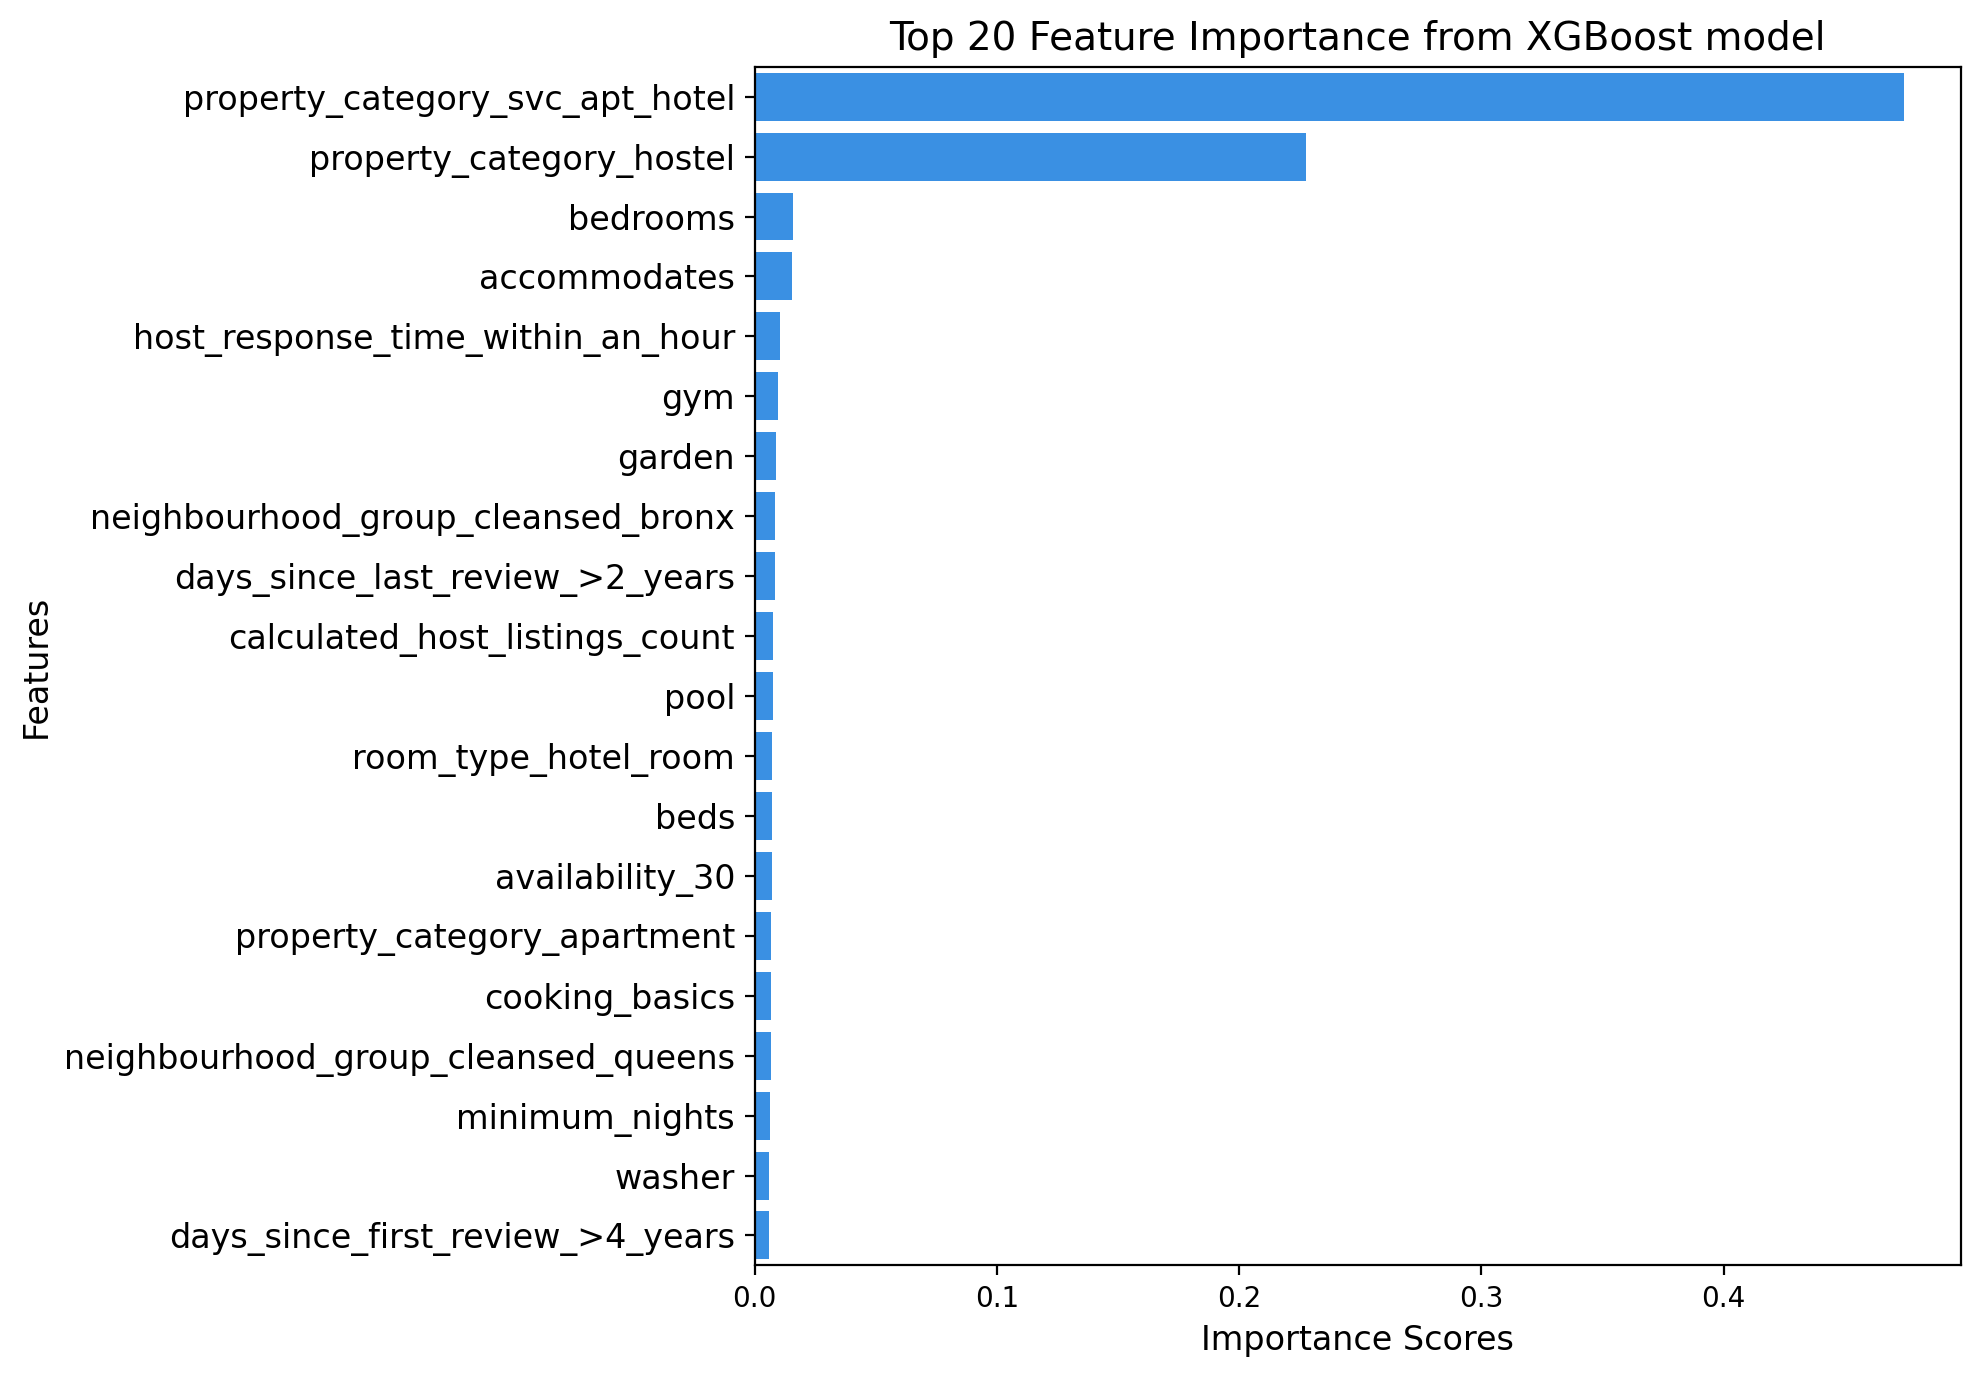

In [ ]:
plt.figure(figsize = (10,7))
sns.barplot(data = feature_impt_df.head(20), x = 'importance', y = 'feature', color = 'dodgerblue')
plt.title('Top 20 Feature Importance from XGBoost model', fontsize=14)
plt.xlabel('Importance Scores',fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

In [ ]:
top_features = feature_impt_df.head(30)
top30_features = top_features.feature.tolist()

In [ ]:
drop_features = [i for i in features if i not in top30_features]

X_train.drop(columns=drop_features, axis=1, inplace=True)
X_test.drop(columns=drop_features, axis=1, inplace=True)

In [ ]:
# Train model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Predictions and Evaluations
train_preds = best_xgb_model.predict(X_train)
test_preds = best_xgb_model.predict(X_test)

# R2 Scores
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

# Print scores
print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Train R2 Score: 0.8013073255154322
Test R2 Score: 0.7619242935487027
Training RMSE: 0.28862245244555146
Testing RMSE: 0.314270635772971


In [ ]:
def ridge_eval(alpha):
    model = Ridge(alpha=alpha)
    model.fit(X_train_ss, y_train)
    preds = model.predict(X_test_ss)
    return -mean_squared_error(y_test, preds)

def lasso_eval(alpha):
    model = Lasso(alpha=alpha)
    model.fit(X_train_ss, y_train)
    preds = model.predict(X_test_ss)
    return -mean_squared_error(y_test, preds)

def elasticnet_eval(alpha, l1_ratio):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_train_ss, y_train)
    preds = model.predict(X_test_ss)
    return -mean_squared_error(y_test, preds)

In [ ]:
ridge_bo = BayesianOptimization(
    f=ridge_eval,
    pbounds={'alpha': (1e-3, 10)},
    random_state=1,
)

lasso_bo = BayesianOptimization(
    f=lasso_eval,
    pbounds={'alpha': (1e-3, 10)},
    random_state=1,
)

elasticnet_bo = BayesianOptimization(
    f=elasticnet_eval,
    pbounds={'alpha': (1e-3, 10), 'l1_ratio': (0, 1)},
    random_state=1,
)

ridge_bo.maximize(init_points=2, n_iter=5)
lasso_bo.maximize(init_points=2, n_iter=5)
elasticnet_bo.maximize(init_points=2, n_iter=5)


|   iter    |  target   |   alpha   |
-------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.55089e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


| 1         | -0.1526   | 4.171     |


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.34351e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


| 2         | -0.1526   | 7.204     |


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.45801e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


| 3         | -0.1526   | 7.397     |


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.99444e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


| 4         | -0.1526   | 9.999     |


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57313e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


| 5         | -0.1527   | 0.002419  |


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.4582e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


| 6         | -0.1526   | 9.091     |


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.83287e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


| 7         | -0.1526   | 9.725     |
|   iter    |  target   |   alpha   |
-------------------------------------
| 1         | -0.4149   | 4.171     |
| 2         | -0.4149   | 7.204     |
| 3         | -0.4149   | 3.977     |
| 4         | -0.4132   | 0.7906    |
| 5         | -0.1553   | 0.002419  |
| 6         | -0.1647   | 0.01181   |
| 7         | -0.4149   | 9.998     |
|   iter    |  target   |   alpha   | l1_ratio  |
-------------------------------------------------
| 1         | -0.4149   | 4.171     | 0.7203    |
| 2         | -0.1532   | 0.002144  | 0.3023    |
| 3         | -0.2069   | 0.1281    | 0.4501    |


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.839e+03, tolerance: 3.808e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


| 4         | -0.173    | 0.4363    | 0.0       |


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+04, tolerance: 3.808e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


| 5         | -0.2238   | 1.731     | 0.0       |
| 6         | -0.4149   | 9.999     | 0.1218    |
| 7         | -0.4149   | 7.152     | 1.0       |


In [ ]:
best_ridge_params = ridge_bo.max['params']
best_lasso_params = lasso_bo.max['params']
best_elasticnet_params = elasticnet_bo.max['params']

# Train models with best parameters
ridge_best = Ridge(**best_ridge_params)
lasso_best = Lasso(**best_lasso_params)
elasticnet_best = ElasticNet(**best_elasticnet_params)

ridge_best.fit(X_train_ss, y_train)
lasso_best.fit(X_train_ss, y_train)
elasticnet_best.fit(X_train_ss, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.99444e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


ElasticNet(alpha=0.002143633798631522, l1_ratio=0.30233257263183977)

In [ ]:
def print_metrics(model, X_train_ss, X_test_ss, y_train, y_test):
    print(f'Mean R2 Score: {round(r2_score(y_test, model.predict(X_test_ss)),4)}')
    print(f'Train Score: {round(model.score(X_train_ss, y_train),4)}')
    print(f'Test Score: {round(model.score(X_test_ss, y_test),4)}')
    print(' ')
    print("Training RMSE:", round(sqrt(mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train_ss)))),4))
    print("Testing RMSE:", round(sqrt(mean_squared_error(np.exp(y_test), np.exp(model.predict(X_test_ss)))),4))

print_metrics(ridge_best, X_train_ss, X_test_ss, y_train, y_test)
print_metrics(lasso_best, X_train_ss, X_test_ss, y_train, y_test)
print_metrics(elasticnet_best, X_train_ss, X_test_ss, y_train, y_test)


Mean R2 Score: 0.6321
Train Score: 0.6253
Test Score: 0.6321
 
Training RMSE: 62.9834
Testing RMSE: 62.2575
Mean R2 Score: 0.6258
Train Score: 0.6183
Test Score: 0.6258
 
Training RMSE: 63.6644
Testing RMSE: 62.9096
Mean R2 Score: 0.6306
Train Score: 0.6234
Test Score: 0.6306
 
Training RMSE: 63.146
Testing RMSE: 62.389
